
Credit Limit Model Performance:
R² Score: 0.9891
MAE: 166.25
RMSE: 198.88

Approval Model Performance:
ROC AUC: 1.0000

Credit Score Model Performance:
R² Score: 0.9494
MAE: 21.58
RMSE: 28.78


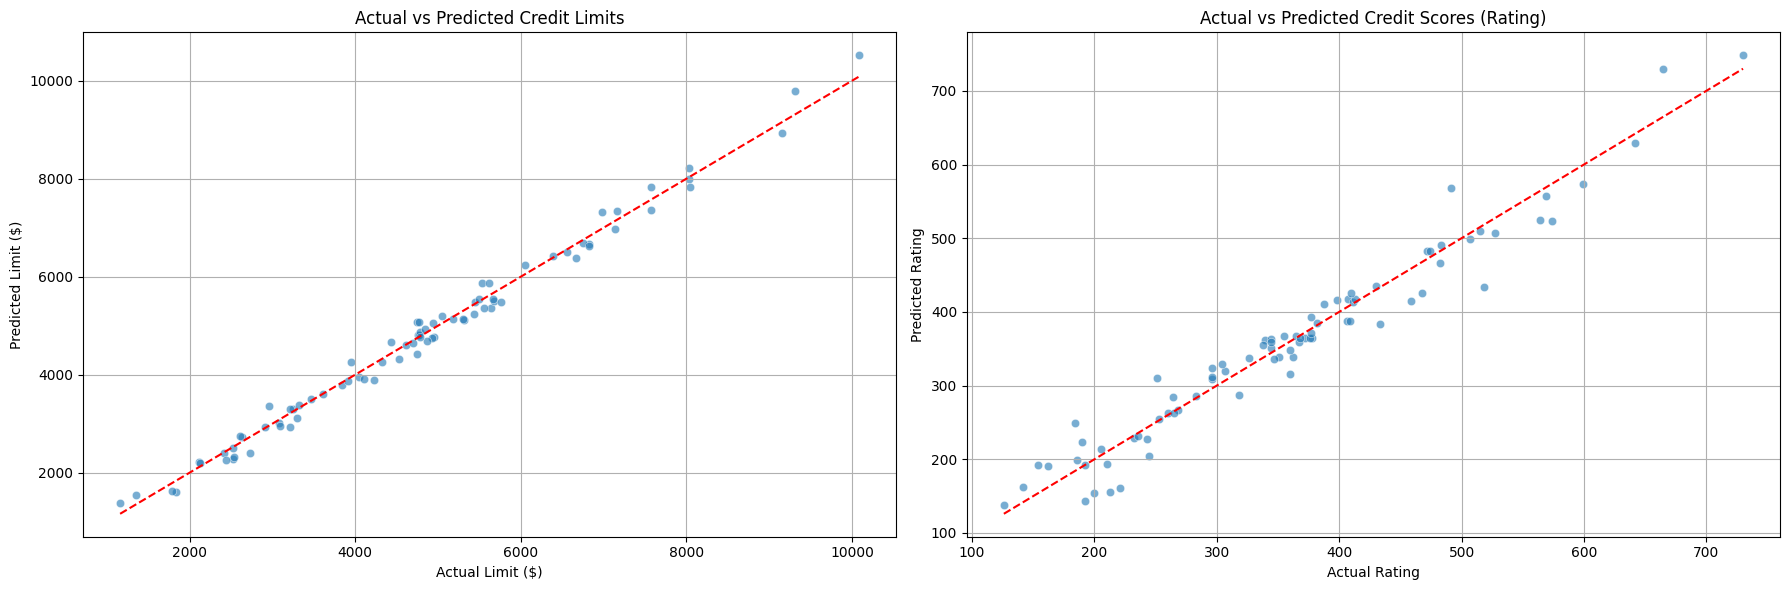

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, roc_auc_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# Load and clean data
df = pd.read_csv('credit.csv')

# 1. Income conversion (multiply by 1000)
df['Income'] = df['Income'] * 1000

# 2. Create synthetic approval target
df['Approved'] = (
    (df['Income'] > 40000) &
    (df['Rating'] > 350) &
    (df['Balance'] < 0.5 * df['Income']) &
    (df['Age'] >= 25) &
    (df['Education'] >= 12)
).astype(int)

# 3. Convert binary features
binary_map = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}
for col in ['Gender', 'Student', 'Married']:
    df[col] = df[col].map(binary_map)

# 4. Feature sets
limit_features = ['Income', 'Rating', 'Cards', 'Age', 'Balance', 'Ethnicity']
approval_features = ['Income', 'Rating', 'Cards', 'Age', 'Balance', 
                    'Education', 'Student', 'Married', 'Ethnicity']
score_features = ['Income', 'Cards', 'Age', 'Balance', 'Education', 'Student', 'Married', 'Gender', 'Ethnicity']

# 5. Preprocessing pipelines
limit_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', limit_features[:-1]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Ethnicity'])
    ])

approval_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', approval_features[:-1]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Ethnicity'])
    ])

score_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', score_features[:-1]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Ethnicity'])
    ])

# 6. Train credit limit model
X_limit = df[limit_features]
y_limit = df['Limit']
X_limit_train, X_limit_test, y_limit_train, y_limit_test = train_test_split(
    X_limit, y_limit, test_size=0.2, random_state=42)

limit_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

limit_preprocessor.fit(X_limit_train)
X_limit_train_processed = limit_preprocessor.transform(X_limit_train)
limit_model.fit(X_limit_train_processed, y_limit_train)

# 7. Train approval model
X_approval = df[approval_features]
y_approval = df['Approved']
X_approval_train, X_approval_test, y_approval_train, y_approval_test = train_test_split(
    X_approval, y_approval, test_size=0.2, random_state=42)

approval_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

approval_preprocessor.fit(X_approval_train)
X_approval_train_processed = approval_preprocessor.transform(X_approval_train)
approval_model.fit(X_approval_train_processed, y_approval_train)

# 8. Train credit score model
X_score = df[score_features]
y_score = df['Rating']
X_score_train, X_score_test, y_score_train, y_score_test = train_test_split(
    X_score, y_score, test_size=0.2, random_state=42)

score_model = RandomForestRegressor(
    n_estimators=250,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

score_preprocessor.fit(X_score_train)
X_score_train_processed = score_preprocessor.transform(X_score_train)
score_model.fit(X_score_train_processed, y_score_train)

# 9. Evaluate models and plot results (Jupyter-friendly version)
from IPython.display import display

# Credit Limit Model Evaluation
X_limit_test_processed = limit_preprocessor.transform(X_limit_test)
limit_pred = limit_model.predict(X_limit_test_processed)

# print("\nCredit Limit Model Performance:")
# print(f"R² Score: {r2_score(y_limit_test, limit_pred):.4f}")
# print(f"MAE: {mean_absolute_error(y_limit_test, limit_pred):,.2f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_limit_test, limit_pred)):,.2f}")

# Approval Model Evaluation
X_approval_test_processed = approval_preprocessor.transform(X_approval_test)
approval_probs = approval_model.predict_proba(X_approval_test_processed)[:,1]

# print("\nApproval Model Performance:")
# print(f"ROC AUC: {roc_auc_score(y_approval_test, approval_probs):.4f}")

# Credit Score Model Evaluation
X_score_test_processed = score_preprocessor.transform(X_score_test)
score_pred = score_model.predict(X_score_test_processed)

# print("\nCredit Score Model Performance:")
# print(f"R² Score: {r2_score(y_score_test, score_pred):.4f}")
# print(f"MAE: {mean_absolute_error(y_score_test, score_pred):.2f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_score_test, score_pred)):.2f}")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Actual vs Predicted Credit Limits
sns.scatterplot(x=y_limit_test, y=limit_pred, alpha=0.6, ax=axes[0])
axes[0].plot([y_limit_test.min(), y_limit_test.max()], 
            [y_limit_test.min(), y_limit_test.max()], 'r--')
axes[0].set_title('Actual vs Predicted Credit Limits')
axes[0].set_xlabel('Actual Limit ($)')
axes[0].set_ylabel('Predicted Limit ($)')
axes[0].grid(True)

# Actual vs Predicted Credit Scores
sns.scatterplot(x=y_score_test, y=score_pred, alpha=0.6, ax=axes[1])
axes[1].plot([y_score_test.min(), y_score_test.max()], 
            [y_score_test.min(), y_score_test.max()], 'r--')
axes[1].set_title('Actual vs Predicted Credit Scores (Rating)')
axes[1].set_xlabel('Actual Rating')
axes[1].set_ylabel('Predicted Rating')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 10. Save artifacts
joblib.dump(limit_model, 'credit_limit_model.pkl')
joblib.dump(limit_preprocessor, 'limit_preprocessor.pkl')
joblib.dump(approval_model, 'approval_model.pkl')
joblib.dump(approval_preprocessor, 'approval_preprocessor.pkl')
joblib.dump(score_model, 'credit_score_model.pkl')
joblib.dump(score_preprocessor, 'score_preprocessor.pkl')

# 11. Prediction class
class CreditPredictor:
    def __init__(self):
        self.limit_model = joblib.load('credit_limit_model.pkl')
        self.limit_preprocessor = joblib.load('limit_preprocessor.pkl')
        self.approval_model = joblib.load('approval_model.pkl')
        self.approval_preprocessor = joblib.load('approval_preprocessor.pkl')
        self.score_model = joblib.load('credit_score_model.pkl')
        self.score_preprocessor = joblib.load('score_preprocessor.pkl')
        
    def predict_limit(self, input_data):
        """Predict credit limit in dollars"""
        input_data['Income'] *= 1000  # Convert from thousands to actual
        input_df = pd.DataFrame([input_data])
        processed = self.limit_preprocessor.transform(input_df)
        return self.limit_model.predict(processed)[0]
    
    def predict_approval(self, input_data):
        """Predict approval probability (0-1)"""
        input_data['Income'] *= 1000
        input_df = pd.DataFrame([input_data])
        processed = self.approval_preprocessor.transform(input_df)
        return self.approval_model.predict_proba(processed)[0][1]
    
    def predict_score(self, input_data):
        """Predict credit score (Rating)"""
        input_data['Income'] *= 1000
        input_df = pd.DataFrame([input_data])
        processed = self.score_preprocessor.transform(input_df)
        return self.score_model.predict(processed)[0]
predictor = CreditPredictor()

# Example Usage

In [2]:
# Example usage
predictor = CreditPredictor()

sample_input = {
    'Income': 85.4,        # Original value (will be ×1000)
    'Rating': 525,
    'Cards': 3,
    'Age': 42,
    'Balance': 500,
    'Education': 16,
    'Student': 0,
    'Married': 1,
    'Ethnicity': 'Caucasian'
}

limit_pred = predictor.predict_limit(sample_input)
prob_pred = predictor.predict_approval(sample_input)

print(f"Predicted Credit Limit: ${limit_pred:,.2f}")
print(f"Approval Probability: {prob_pred:.1%}")

Predicted Credit Limit: $7,337.73
Approval Probability: 93.9%
